In [1]:
'''imports'''

'''basic imports'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
'''import geopandas as gp'''
import scipy
import sparse
from scipy.sparse import csr_matrix

'''dataframe handling'''
'''import pandas as pd'''
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import dask_ml.cluster
import dask_ml.preprocessing
import joblib

import datetime as date

'''learning'''
import sklearn
from sklearn import metrics
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA

In [2]:
'''Lists'''


'''CSV / dataframe column names'''
allcols=['agency_collection_num','collection_id','code','longitude','latitude','collection_date','aedes_dorsalis_males',
         'aedes_dorsalis_females-mixed','aedes_melanimon_males','aedes_melanimon_females-mixed','aedes_nigromaculis_males',
         'aedes_nigromaculis_females-mixed','aedes_sierrensis_males','aedes_sierrensis_females-mixed',
         'aedes_squamiger_males','aedes_squamiger_females-mixed','aedes_vexans_males','aedes_vexans_females-mixed',
         'aedes_washinoi_males','aedes_washinoi_females-mixed','anopheles_franciscanus_males',
         'anopheles_franciscanus_females-mixed','anopheles_freeborni_males','anopheles_freeborni_females-mixed',
         'anopheles_occidentalis_males','anopheles_occidentalis_females-mixed','anopheles_punctipennis_males', 
         'anopheles_punctipennis_females-mixed','culex_apicalis_males','culex_apicalis_females-mixed',
         'culex_erythrothorax_males','culex_erythrothorax_females-mixed','culex_pipiens_males',
         'culex_pipiens_females-mixed','culex_restuans_males','culex_restuans_females-mixed','culex_stigmatosoma_males',
         'culex_stigmatosoma_females-mixed','culex_tarsalis_males','culex_tarsalis_females-mixed','culiseta_incidens_males',
         'culiseta_incidens_females-mixed','culiseta_inornata_males','culiseta_inornata_females-mixed',
         'culiseta_particeps_males','culiseta_particeps_females-mixed']

rawabundcols = ['aedes_dorsalis_males','aedes_dorsalis_females-mixed','aedes_melanimon_males','aedes_melanimon_females-mixed',
             'aedes_nigromaculis_males','aedes_nigromaculis_females-mixed','aedes_sierrensis_males',
             'aedes_sierrensis_females-mixed','aedes_squamiger_males','aedes_squamiger_females-mixed','aedes_vexans_males',
             'aedes_vexans_females-mixed','aedes_washinoi_males','aedes_washinoi_females-mixed','anopheles_franciscanus_males',
             'anopheles_franciscanus_females-mixed','anopheles_freeborni_males','anopheles_freeborni_females-mixed',
             'anopheles_occidentalis_males','anopheles_occidentalis_females-mixed','anopheles_punctipennis_males',
             'anopheles_punctipennis_females-mixed','culex_apicalis_males','culex_apicalis_females-mixed',
             'culex_erythrothorax_males','culex_erythrothorax_females-mixed','culex_pipiens_males',
             'culex_pipiens_females-mixed','culex_restuans_males','culex_restuans_females-mixed','culex_stigmatosoma_males',
             'culex_stigmatosoma_females-mixed','culex_tarsalis_males','culex_tarsalis_females-mixed','culiseta_incidens_males',
             'culiseta_incidens_females-mixed','culiseta_inornata_males','culiseta_inornata_females-mixed',
             'culiseta_particeps_males','culiseta_particeps_females-mixed']

'''column names of findata'''
fincols = ['agency_collection_num','collection_id','code','longitude','latitude','collection_date','dorsalis','melanimon',
           'nigromaculis','sierrensis','squamiger','vexans','washinoi','franciscanus','freeborni','occidentalis','punctipennis',
           'apicalis','erythrothorax','pipiens','restuans','stigmatosoma','tarsalis','incidens','inornata','particeps']

In [3]:
'''Mosquito species library'''
aedes = ['dorsalis', 'melanimon', 'nigromaculis', 'sierrensis', 'squamiger', 'vexans', 'washinoi']
anopheles = ['franciscanus', 'freeborni', 'occidentalis', 'punctipennis']
culex = ['apicalis', 'erythrothorax', 'pipiens', 'restuans', 'stigmatosoma', 'tarsalis']
culiseta = ['incidens', 'inornata', 'particeps']
genera_list = ['aedes', 'anopheles', 'culex', 'culiseta']
flight_types = [1,2,3,4,5]
'''most culex higher risk for wnv, some aedes very high risk -- focus on tarsalis, pipiens, ery'''
'''anopheles higher malaria risk, mostly freeborni'''
'''culiseta is low risk'''
risks = ['low', 'medium', 'high']
aggression_lvl = []
class mosquito:
    def __init__(self, genera, species, flight_distance = None, dis_risk = 'low', biting_agg = None):
        if genera in genera_list:
            self.genera = genera
        else: 
            print('not real genera')
        if species in aedes:
            self.species = species
            
        elif species in anopheles:
            self.species = species
            if self.species == 'freeborni':
                self.dis_risk = 'medium'
        elif species in culex:
            self.species = species
            if self.species == 'pipiens' or 'tarsalis' or 'erythrothorax':
                self.dis_risk = 'high'
            else:
                self.dis_risk = 'medium'
        elif species in culiseta:
            self.species = species
        else:
            print('not a species')
        if flight_distance != None:
            self.flight_distance = flight_distance
        

In [4]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        
        
        mean = df.loc[:, (col)].mean()
        sd = df.loc[:, (col)].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [5]:
def remove_low_totals(df):
    df = df[df['total'] >= 5]
    return df


In [6]:
'''quickrun pca on a dataframe'''
def quick_pca(df, components):
    quickpca = PCA(n_components = components)
    retarr = quickpca.fit_transform(df)
    retdf = pd.DataFrame(retarr)
    
    return retdf

In [7]:
'''data management'''
'''findata is the dataframe containing all processed abundance data with supplemental info needed later'''
'''testdata is the processed abundance dataframe to be used in the clustering'''


supportcols = ['collection_id','code','site_name','longitude','latitude','collection_date', 'total']

findata = pd.read_csv (r'C:\Users\Andre\OneDrive\documents\smallabundance1622.csv', usecols = supportcols, parse_dates=['collection_date'])


proabundcols = ['dorsalis', 'melanimon', 'nigromaculis', 'sierrensis', 'squamiger','vexans', 'washinoi', 'franciscanus', 
                'freeborni', 'occidentalis', 'punctipennis', 'apicalis', 'erythrothorax','pipiens','restuans', 'stigmatosoma', 
                'tarsalis', 'incidens', 'inornata', 'particeps']


abunddata =pd.read_csv (r'C:\Users\Andre\OneDrive\documents\smallabundance1622.csv', usecols = rawabundcols,dtype = {'aedes_dorsalis_males':np.int8,'aedes_dorsalis_females-mixed':np.int8,'aedes_melanimon_males':np.int8,'aedes_melanimon_females-mixed':np.int8,
             'aedes_nigromaculis_males':np.int8,'aedes_nigromaculis_females-mixed':np.int8,'aedes_sierrensis_males':np.int8,
             'aedes_sierrensis_females-mixed':np.int8,'aedes_squamiger_males':np.int8,'aedes_squamiger_females-mixed':np.int8,'aedes_vexans_males':np.int8,
             'aedes_vexans_females-mixed':np.int8,'aedes_washinoi_males':np.int8,'aedes_washinoi_females-mixed':np.int8,'anopheles_franciscanus_males':np.int8,
             'anopheles_franciscanus_females-mixed':np.int8,'anopheles_freeborni_males':np.int8,'anopheles_freeborni_females-mixed':np.int8,
             'anopheles_occidentalis_males':np.int8,'anopheles_occidentalis_females-mixed':np.int8,'anopheles_punctipennis_males':np.int8,
             'anopheles_punctipennis_females-mixed':np.int8,'culex_apicalis_males':np.int8,'culex_apicalis_females-mixed':np.int8,
             'culex_erythrothorax_males':np.int8,'culex_erythrothorax_females-mixed':np.int8,'culex_pipiens_males':np.int8,
             'culex_pipiens_females-mixed':np.int8,'culex_restuans_males':np.int8,'culex_restuans_females-mixed':np.int8,'culex_stigmatosoma_males':np.int8,
             'culex_stigmatosoma_females-mixed':np.int8,'culex_tarsalis_males':np.int8,'culex_tarsalis_females-mixed':np.int8,'culiseta_incidens_males':np.int8,
             'culiseta_incidens_females-mixed':np.int8,'culiseta_inornata_males':np.int8,'culiseta_inornata_females-mixed':np.int8,
             'culiseta_particeps_males':np.int8,'culiseta_particeps_females-mixed':np.int8}, low_memory=False)

testdata = pd.read_csv (r'C:\Users\Andre\OneDrive\documents\smallabundance1622.csv', usecols = [])

for x in proabundcols: 
    sera = abunddata.iloc[:,2*proabundcols.index(x)]
    serb = abunddata.iloc[:,(2*proabundcols.index(x))+1]
    serret = sera.add(serb, fill_value = 0)
    findata[x] = serret 
    testdata[x] = serret


Text(0, 0.5, 'Cumulative Explained Variance')

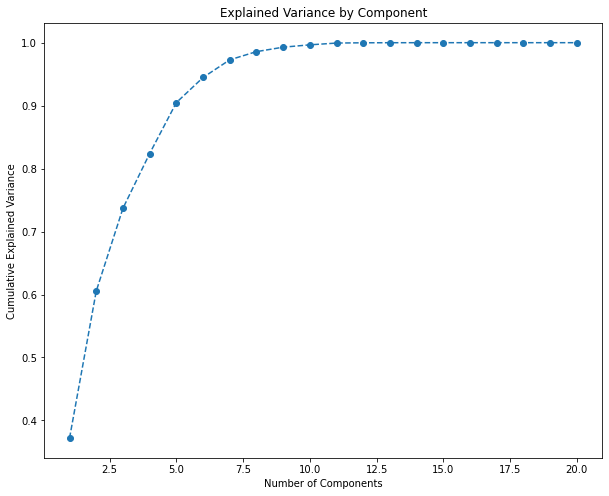

In [8]:
'''finding number of components using PCA'''
dimred = testdata.copy()
pca = PCA()
pca.fit(dimred)
pca.explained_variance_ratio_
plt.figure(figsize=(10,8))
plt.plot(range(1,21), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

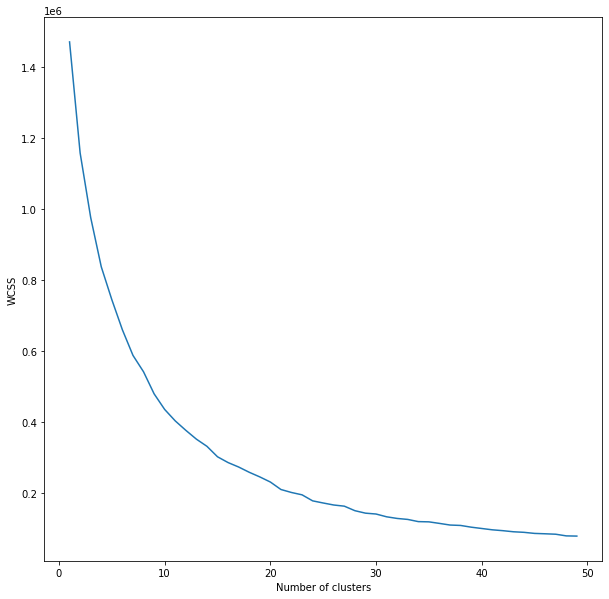

In [9]:
'''numcluster finder'''

pcaholderA = testdata.copy()
holderA = quick_pca(pcaholderA, 10)
kmeans = sklearn.cluster.KMeans(n_clusters=9, random_state = 0)
labelA = kmeans.fit(holderA)
wcss = []
for i in range(1,50):
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(holderA)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,50), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


<AxesSubplot:xlabel='collection_id', ylabel='total'>

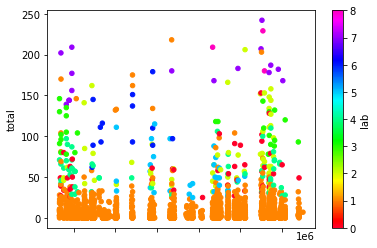

In [10]:
'''no pca analysis cluster then display'''

holderA = testdata.copy()

kmeans = sklearn.cluster.KMeans(n_clusters=9, random_state = 0)
labelA = kmeans.fit(holderA)
holderA['lab'] = labelA.labels_

holderA['collection_id'] = findata['collection_id']
holderA['total'] = findata['total']

holderA2 = remove_outliers(holderA, columns = ['total'] , n_std = 1)

holderA2.plot.scatter('collection_id', 'total', c='lab', colormap='gist_rainbow')

<AxesSubplot:xlabel='collection_id', ylabel='total'>

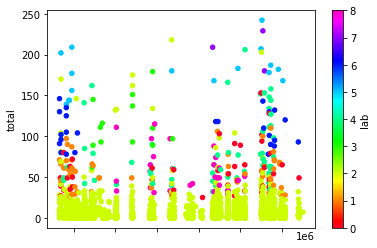

In [11]:
'''pca analysis cluster then display'''

pcaholderB = testdata.copy()
holderB = quick_pca(pcaholderB,11)

kmeans = sklearn.cluster.KMeans(n_clusters=9, random_state = 0)
labelB = kmeans.fit(holderB)
holderB['lab'] = labelB.labels_

holderB['collection_id'] = findata['collection_id']
holderB['total'] = findata['total']

holderB2 = remove_outliers(holderB, columns = ['total'] , n_std = 1)

holderB2.plot.scatter('collection_id', 'total', c='lab', colormap='gist_rainbow')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

# define a generator function to read in data in chunks
def read_data_chunks(filename, chunksize=100000):
    for chunk in pd.read_csv(filename, chunksize=chunksize):
        yield chunk

# define a function to preprocess data and apply PCA
def preprocess_and_pca(data, n_components=10):
    # drop any rows with missing values
    data.dropna(inplace=True)
    # scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    # apply PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)
    # return the PCA results
    return pca_data

# define a function to perform clustering on PCA data
def cluster_pca_data(pca_data, n_clusters=9):
    # perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(pca_data)
    # return the labels
    return labels

# define a function to plot clustered data
def plot_clustered_data(data, labels, x_col='collection_id', y_col='total'):
    data['lab'] = labels
    data2 = remove_outliers(data, columns=[y_col], n_std=1)
    data2.plot.scatter(x_col, y_col, c='lab', colormap='gist_rainbow')
    plt.show()

# define a function to remove outliers from data
def remove_outliers(data, columns, n_std=3):
    for col in columns:
        data = data[np.abs(data[col] - data[col].mean()) <= n_std * data[col].std()]
    return data

# main function to read data, preprocess, apply PCA, perform clustering, and plot results
def main(filename, chunksize=100000, n_components=10, n_clusters=9):
    # initialize variables
    pca_data = None
    all_labels = []
    # loop through data chunks and process each one
    for i, data_chunk in enumerate(read_data_chunks(filename, chunksize=chunksize)):
        # preprocess and apply PCA to the chunk
        chunk_pca_data = preprocess_and_pca(data_chunk, n_components=n_components)
        # perform clustering on the PCA data
        chunk_labels = cluster_pca_data(chunk_pca_data, n_clusters=n_clusters)
        # concatenate the labels with previous results
        all_labels = np.concatenate([all_labels, chunk_labels])
    # plot the clustered data
    data = pd.concat(read_data_chunks(filename, chunksize=chunksize))
    plot_clustered_data(data, all_labels)

# example usage

    main(r'C:\Users\Andre\OneDrive\documents\smallabundance1622.csv', chunksize=100000, n_components=11, n_clusters=9)


In [13]:
import folium


def map_clusters(df, lat_col, lon_col, cluster_col):
    """
    Given a dataframe, a latitude column, a longitude column, and a cluster column,
    this function returns a folium map with a marker for each row in the dataframe,
    colored based on the value in the cluster column.
    """
    # Define a list of colors to use for the markers
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Create a folium map centered on the median latitude and longitude
    m = folium.Map(location=[df[lat_col].median(), df[lon_col].median()], zoom_start=12)
    
    # Cast cluster_col to integer to avoid indexing errors
    df.loc[:, cluster_col] = df[cluster_col].astype(int)
    
    # Add a marker for each row in the dataframe
    for i, row in df.iterrows():
        folium.Marker(
            location=[row[lat_col], row[lon_col]],
            icon=folium.Icon(color=colors[int(row[cluster_col]) % len(colors)]),
            popup=row[cluster_col]
        ).add_to(m)
    
    return m


In [14]:
'''pca analysis cluster then map'''

pcaholderB = testdata.copy()
holderB = quick_pca(pcaholderB,11)

kmeans = sklearn.cluster.KMeans(n_clusters=20, random_state = 0)
labelB = kmeans.fit(holderB)
holderB['lab'] = labelB.labels_

holderB['collection_id'] = findata['collection_id']
holderB['total'] = findata['total']

holderB2 = remove_low_totals(holderB)
holderB2.loc[:, 'latitude'] = findata.loc[:, 'latitude']
holderB2.loc[:, 'longitude'] = findata.loc[:, 'longitude']
holderB2.loc[:, 'lab'] = holderB2['lab'].astype(int)



map_clusters(holderB2, 'latitude', 'longitude', 'lab')


C:\Users\andre\AppData\Local\Temp\ipykernel_20608\1664175133.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holderB2.loc[:, 'latitude'] = findata.loc[:, 'latitude']
C:\Users\andre\AppData\Local\Temp\ipykernel_20608\1664175133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holderB2.loc[:, 'longitude'] = findata.loc[:, 'longitude']
C:\Users\andre\AppData\Local\Temp\ipykernel_20608\1664175133.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin